In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms

# Load data

In [2]:
batch_size = 32
train_transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.131],[0.308])])
test_transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize([0.131],[0.308])])
train_data = datasets.MNIST('./data/mnist',
                           train = True,
                           transform = train_transforms,
                           download=True)
test_data = datasets.MNIST('./data/mnist',
                          train = False,
                          transform = test_transforms,
                          download=True)

train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size = batch_size,
                                          shuffle = True)

#no need to shuffle for tests
test_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size = batch_size,
                                          shuffle = False)


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# Data exploration

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
inputs, labels = next(iter(train_loader))
print(inputs.shape, labels.shape)
#32 samples per batch, each of 28*28 pixels, with 1 color channel
inputs[0]

torch.Size([32, 1, 28, 28]) torch.Size([32])


tensor([[[-0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253],
         [-0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253],
         [-0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253],
         [-0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253, -0.4253,
          -0.4253, -0.4253, -0.4253, -0.4253, -0

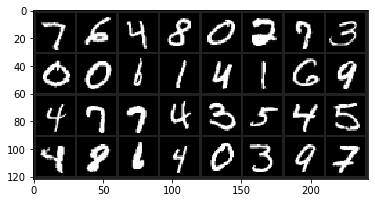

In [11]:
def imshow(img):
    img = img.numpy().transpose((1,2,0))
    img = img*0.308+0.131
    img = np.clip(img,0,1)
    plt.imshow(img)
out = torchvision.utils.make_grid(inputs)
imshow(out)

# Model

In [41]:
class Linear_classifier(nn.Module):
    def __init__(self,layers=[512,128],input_size = 784,out_channels=10):
        super().__init__()
        layers = [input_size]+layers
        layers.append(out_channels)
        L = []
        for i in range(1,len(layers)):
            L.append(nn.Linear(layers[i-1],layers[i]))
            L.append(nn.ReLU())
        L.append(nn.Softmax())
        self.network = nn.Sequential(*L)
    
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.network(x)
        return x


    

Linear_classifier(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=None)
  )
)


# Training

In [46]:
def train(lr=1e-3,epochs=20,mode='SGD'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Linear_classifier().to(device)
    print(model)
    print('lr: {}, epochs: {}'.format(lr, epochs))
    if mode=='SGD':
        optimizer = torch.optim.SGD(model.parameters(),lr = lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(),lr = lr)
    criteria = nn.CrossEntropyLoss()
    import time

    for i in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criteria(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss = running_loss+loss.item()
        running_loss = running_loss/len(train_loader)
        cur_time = time.time()
        print('Epoch: {}, loss: {}, time: {}'.format(i, running_loss,cur_time-start_time))
        start_time = cur_time
        
    #test
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criteria(outputs,labels)
            _, predicted = torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    accuracy = 100.0*correct/total

    print("accuracy is {} percentage".format(accuracy))
    return model

# Test

In [47]:
model1 = train(lr=0.03,epochs=20)

Linear_classifier(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=None)
  )
)
lr: 0.03, epochs: 20
Epoch: 0, loss: 1.8653203535715739, time: 24.240259170532227
Epoch: 1, loss: 1.7121058294932048, time: 24.04960012435913
Epoch: 2, loss: 1.7005050527572632, time: 24.025945901870728
Epoch: 3, loss: 1.6929047777811685, time: 24.204917192459106
Epoch: 4, loss: 1.6871904738108316, time: 24.40277075767517
Epoch: 5, loss: 1.6827733764648438, time: 23.927614212036133
Epoch: 6, loss: 1.6789499739329021, time: 23.402230978012085
Epoch: 7, loss: 1.6443322028477987, time: 23.324887990951538
Epoch: 8, loss: 1.5912256618499756, time: 24.462833166122437
Epoch: 9, loss: 1.5860878664016724, time: 24.474854946136475
Epoch: 10, loss: 1.5826284267425537, time: 24.25729775428772


In [48]:
model2 = train(lr=0.05,epochs=20)

Linear_classifier(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=None)
  )
)
lr: 0.05, epochs: 20
Epoch: 0, loss: 1.9550402484258016, time: 24.40858817100525
Epoch: 1, loss: 1.85327001508077, time: 24.220336198806763
Epoch: 2, loss: 1.838732870165507, time: 24.288219928741455
Epoch: 3, loss: 1.8309776888529459, time: 24.207036018371582
Epoch: 4, loss: 1.8257667839050293, time: 24.120702028274536
Epoch: 5, loss: 1.8219868227640788, time: 24.206580877304077
Epoch: 6, loss: 1.8191900794347127, time: 24.16806697845459
Epoch: 7, loss: 1.8169230650583903, time: 24.331862688064575
Epoch: 8, loss: 1.8152085454940796, time: 24.128501892089844
Epoch: 9, loss: 1.8138571093877156, time: 24.18015480041504
Epoch: 10, loss: 1.8126553833007812, time: 24.11116600036621
Epoc

In [49]:
model3 = train(lr=0.01,epochs=50)

Linear_classifier(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=None)
  )
)
lr: 0.01, epochs: 50
Epoch: 0, loss: 2.129818073908488, time: 24.080988883972168
Epoch: 1, loss: 1.7400812965393067, time: 24.8941650390625
Epoch: 2, loss: 1.6670827271779378, time: 24.320021152496338
Epoch: 3, loss: 1.6411245574951172, time: 24.07512092590332
Epoch: 4, loss: 1.6310888650894164, time: 24.034185886383057
Epoch: 5, loss: 1.6244946219762166, time: 24.036355018615723
Epoch: 6, loss: 1.6195142652511596, time: 24.098693132400513
Epoch: 7, loss: 1.6154249067306519, time: 24.087377071380615
Epoch: 8, loss: 1.6116558298746744, time: 24.026623249053955
Epoch: 9, loss: 1.6084177863438924, time: 24.03950786590576
Epoch: 10, loss: 1.6055069213231405, time: 24.047260761260986
Ep

In [50]:
model4 = train(lr=0.01,epochs=20,mode='Adam')

Linear_classifier(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=None)
  )
)
lr: 0.01, epochs: 20
Epoch: 0, loss: 2.363519980239868, time: 35.35069227218628
Epoch: 1, loss: 2.363634099451701, time: 38.660786867141724
Epoch: 2, loss: 2.3636341013590494, time: 38.3831102848053
Epoch: 3, loss: 2.363634102757772, time: 38.38648819923401
Epoch: 4, loss: 2.3636341040293374, time: 38.41402864456177
Epoch: 5, loss: 2.3636341053009033, time: 38.64765691757202
Epoch: 6, loss: 2.3636341068267823, time: 38.38868474960327
Epoch: 7, loss: 2.363634105173747, time: 38.293275117874146
Epoch: 8, loss: 2.363634103393555, time: 37.99690890312195
Epoch: 9, loss: 2.363634108479818, time: 38.30868577957153
Epoch: 10, loss: 2.3636341086069743, time: 38.563183069229126
Epoch: 11, l

In [51]:
model4 = train(lr=0.001,epochs=20,mode='Adam')

Linear_classifier(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=None)
  )
)
lr: 0.001, epochs: 20
Epoch: 0, loss: 1.596229276974996, time: 29.52825117111206
Epoch: 1, loss: 1.513808993212382, time: 30.539342880249023
Epoch: 2, loss: 1.5034395808537802, time: 31.73619294166565
Epoch: 3, loss: 1.5025473094940185, time: 32.89376187324524
Epoch: 4, loss: 1.4989228372573853, time: 33.86837577819824
Epoch: 5, loss: 1.500059866841634, time: 34.27565813064575
Epoch: 6, loss: 1.4964721212387084, time: 35.40650820732117
Epoch: 7, loss: 1.4984564292907714, time: 35.563862800598145
Epoch: 8, loss: 1.493804841931661, time: 35.99980068206787
Epoch: 9, loss: 1.4947130980809529, time: 35.73797297477722
Epoch: 10, loss: 1.4957053396224975, time: 35.02749800682068
Epoch: 11

In [52]:
model4 = train(lr=0.001,epochs=5,mode='Adam')

Linear_classifier(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): ReLU()
    (6): Softmax(dim=None)
  )
)
lr: 0.001, epochs: 5
Epoch: 0, loss: 1.6744712434132893, time: 29.775541067123413
Epoch: 1, loss: 1.5162453948338825, time: 30.73548913002014
Epoch: 2, loss: 1.5054007658640545, time: 31.64878487586975
Epoch: 3, loss: 1.5018550045013428, time: 33.25916504859924
Epoch: 4, loss: 1.500238242594401, time: 34.56008005142212
accuracy is 96.57333333333334 percentage
